In [255]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools


## Simulation Parameters

In [256]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

## Robot Parameters

In [257]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.1

## Data Generation

### Trajectory Generation

In [258]:
# Function
# Function for dynamics
def dataset_dyn_gen_3R(dt,num_traj,num_snaps,num_states,num_inputs, robot_pars):
  #define parameters
  # link lengths
    a1 = robot_pars['a1']
    a2 = robot_pars['a2']
    a3 = robot_pars['a3']

    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    m3 = robot_pars['m3']

    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I2']
    I3 = robot_pars['I3']

    #position of CM
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    l3 = robot_pars['l3']

    #dynamic friction coefficient
    fd = robot_pars['fd']

    # gravity
    g = 9.81*0

    # matrix initializations
    X = np.empty((num_traj,num_snaps+1,num_states)) # Joint space matrix
    U = np.empty((num_traj,num_snaps,num_inputs)) # input matrix
    x_end = np.empty((num_traj,num_snaps+1,2)) # position of end effector

    for i in range(num_traj):
        # initialize the values for the trajectory
        # joint angles
        X[i,0,0:3] = np.pi*(2*np.random.rand(1,1,3)-1) 
        # joint velocities
        X[i,0,3:6] = 0.1*(2*np.random.rand(1,1,3)-1) 
        # end effector positions
        x_end[i,0,0]= a1*np.cos(X[i,0,0])+a2*np.cos(X[i,0,0]+X[i,0,1])+a3*np.cos(X[i,0,0]+X[i,0,1]+X[i,0,2])
        x_end[i,0,1]= a1*np.sin(X[i,0,0])+a2*np.sin(X[i,0,0]+X[i,0,1])+a3*np.sin(X[i,0,0]+X[i,0,1]+X[i,0,2])


        for j in range(num_snaps):

            #define thetas and theta_dots for convenience
            th1 = X[i,j,0]
            th2 = X[i,j,1]
            th3 = X[i,j,2]
            th1_dot = X[i,j,3]
            th2_dot = X[i,j,4]
            th3_dot = X[i,j,5]

            theta_dot = X[i,j,3:6].reshape(num_inputs,1)


            # mass matrix
            m11 = I1+I2+I3+m1*l1**2+m2*(a1**2+l2**2+2*a1*l2*np.cos(th2))+m3*(a1**2+a2**2+l3**2+2*a1*a2*np.cos(th2)+2*a1*l3*np.cos(th2+th3)+2*a2*l3*np.cos(th3))
            m22 = I2+I3+m2*l2**2+m3*(a2**2+l3**2+2*a2*l3*np.cos(th3))
            m33 = I3+m3*l3**2
            m12 = I2+I3+m2*(l2**2+a1*l2*np.cos(th2))+m3*(a2**2+l3**2+a1*a2*np.cos(th2)+a1*l3*np.cos(th2+th3)+2*a2*l3*np.cos(th3))
            m21 = m12
            m13 = I3+m3*(l3**2+a1*l3*np.cos(th2+th3)+a2*l3*np.cos(th3))
            m31 = m13
            m23 = I3+m3*(l3**2+a2*l3*np.cos(th3))
            m32 = m23


            M = np.array([[m11,m12,m13],[m21,m22,m23],[m31,m32,m33]])

            # coriolis terms
            c11 = -(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th3_dot-(m2+m3*a1*a2*np.sin(th2)+a1*l2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th2_dot
            c22 = -m3*a2*l3*np.sin(th3)*th3_dot
            c33 = -(m3*a1*a2*np.sin(th2))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot
            c12 = -(m2*a1*l2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3)+m3*a1*a2*np.sin(th2))*th1_dot-(m3*a1*a2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3)+m2*a1*l2*np.sin(th2))*th2_dot-(m3*a2*l3*np.sin(th3)+m3*a1*l3*np.sin(th2+th3))*th3_dot
            c13 = -(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th1_dot-(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th3_dot
            c21 = (m2*a1*l2*np.sin(th2)+m3*a1*a2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th1_dot-(m3*a2*l3*np.sin(th3))*th3_dot
            c23 = -(m3*a2*l3*np.sin(th3))*th1_dot-(m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot
            c31 = (m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th1_dot+(m3*a2*l3*np.sin(th3))*th2_dot
            c32 = (m3*a2*l3*np.sin(th3))*th1_dot+(m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot

            C = np.array([[c11,c12,c13],[c21,c22,c23],[c31,c32,c33]])


            # gravity terms
            g1 = (m2*l2+m3*a2)*g*np.cos(th1+th2)+m3*l3*g*np.cos(th1+th2+th3)+(m1*l1+m3*a1+m2*a1)*g*np.cos(th1)
            g2 = (m2*l2+m3*a2)*g*np.cos(th1+th2)+m3*l3*g*np.cos(th1+th2+th3)
            g3 = m3*l3*g*np.cos(th1+th2+th3)


            G = np.array([[g1],[g2],[g3]])

            # inputs
            U[i,j,:] = 1*(2*np.random.rand(1,1,3)-1)
            tau = np.array([[U[i,j,0]],[U[i,j,1]],[U[i,j,2]]])

            # theta evolution
            th_ddot = np.matmul(np.linalg.inv(M),(tau-G-np.matmul(C,theta_dot)-(fd*theta_dot))).reshape(1,1,3)
            X[i,j+1,3:6] = X[i,j,3:6] + th_ddot*dt
            X[i,j+1,0:3] = X[i,j,0:3] + X[i,j,3:6]*dt +(1/2)*th_ddot*dt**2

            x_end[i,j+1,0]= a1*np.cos(X[i,j+1,0])+a2*np.cos(X[i,j+1,0]+X[i,j+1,1])+a3*np.cos(X[i,j+1,0]+X[i,j+1,1]+X[i,j+1,2])
            x_end[i,j+1,1]= a1*np.sin(X[i,j+1,0])+a2*np.sin(X[i,j+1,0]+X[i,j+1,1])+a3*np.sin(X[i,j+1,0]+X[i,j+1,1]+X[i,j+1,2])

    return x_end,X,U

In [259]:
# Trajectories
X_end,X_full, U_full = dataset_dyn_gen_3R(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)


### Dataset Visualization

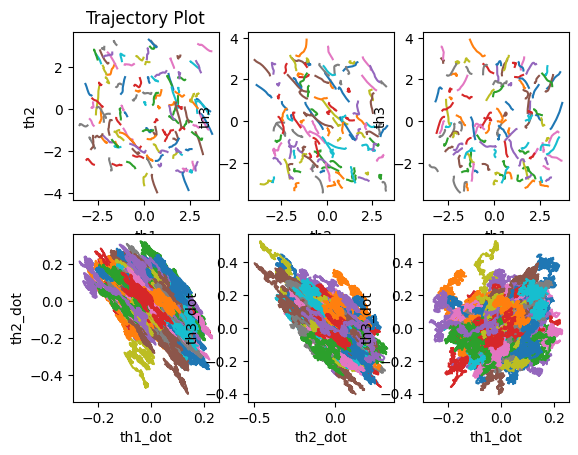

In [260]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])

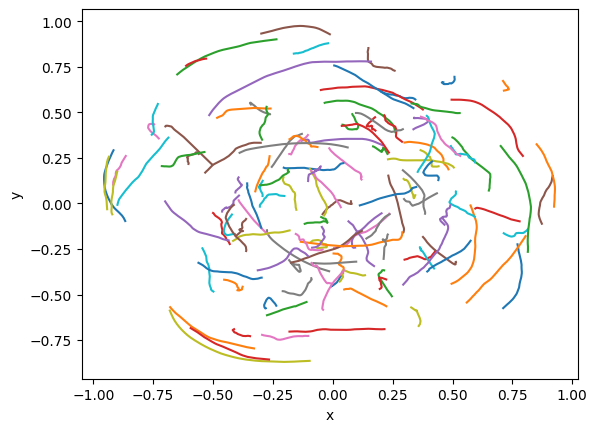

In [261]:
#x and y positions of the end effector
plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

In [262]:
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


In [263]:
## Reshape the matricies
X = np.zeros((num_states, num_snaps*num_traj))
X_dash = np.zeros((num_states, num_snaps*num_traj)) # one step ahead
U_flat = np.zeros((num_inputs,num_snaps*num_traj))
for i in range(num_traj):
    # Reshape the matricies and develope the snapshot matries
    X[:, i*num_snaps:(i+1)*num_snaps] = X_full[i,:-1,:].T
    X_dash[:, i*num_snaps:(i+1)*num_snaps] = X_full[i,1:,:].T
    U_flat[:, i*num_snaps:(i+1)*num_snaps] = U_full[i,:,:].T

In [264]:
print("Shape for X_full = ", X_full.shape)
print("Shape for X = ", X.shape)
print("Shape for X_dash = ", X_dash.shape)
print("Shape for U_full = ", U_full.shape)
print("Shape for U_flat = ", U_flat.shape)

Shape for X_full =  (125, 1001, 6)
Shape for X =  (6, 125000)
Shape for X_dash =  (6, 125000)
Shape for U_full =  (125, 1000, 3)
Shape for U_flat =  (3, 125000)


***Koopman Implementation***

***Polynomial basis***

In [265]:
def indicies(max_power,num_states, state_interaction):
    arr = np.tile(np.arange(max_power+1),num_states)
    base_list = list(itertools.combinations(arr, num_states))
    full_arr = np.unique(np.array(base_list),axis = 0)
    dim = full_arr.shape[0]
    del_index = []
    for i in range(full_arr.shape[0]):
        if np.sum(full_arr[i,:])==1:
            del_index.append(i)
        if state_interaction == False:
            if np.sum(full_arr[i,:]) > np.max(full_arr[i,:]):
                del_index.append(i)
    red_arr = np.delete(full_arr, del_index, axis = 0) # remove colums with linear and contant polynomials
    return np.vstack((np.identity(num_states),red_arr)) # add the linear components to make change to base states easy



In [266]:
print(indicies(2,6,state_interaction=True))

print(indicies(1,6,state_interaction=True).shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [2. 2. 2. 2. 2. 0.]
 [2. 2. 2. 2. 2. 1.]
 [2. 2. 2. 2. 2. 2.]]
(64, 6)


In [267]:
def lift_poly(max_power, data, inputs,state_interaction,model_type):
    num_states = data.shape[0]
    index = indicies(max_power,num_states,state_interaction)
    dim = index.shape[0] # lifted state dimension
    length = data.shape[1]
    #print(dim,length)
    num_inputs = inputs.shape[0]
    #print(num_inputs) 
    
    if model_type == 'linear':
        data_lifted = np.ones((dim,length))   
    elif model_type == 'bilinear':    
        data_lifted = np.ones(((num_inputs+1)*dim,length))
    else:
        print("invalid model type")
        return None
    
    for i in range(length):
        for j in range(dim):
            for k in range(num_states):
                data_lifted[j,i] = data_lifted[j,i]*(data[k,i]**index[j,k])
            if model_type == "bilinear":
                for l in range(num_inputs):
                    data_lifted[j+(l+1)*dim,i] = data_lifted[j,i]*inputs[l,i]
    return data_lifted

In [268]:
def generate_centres(num_centres, data):
    # centres = np.vstack((0.1*(2*np.random.rand(int(num_states/2),num_centres) - 1),
    #                     np.pi*(2*np.random.rand(int(num_states/2),num_centres) - 1)))
    num_states = data.shape[0]
    length = data.shape[1]
    idx = np.random.choice(np.arange(length),num_centres)
    centres = np.zeros((num_states,num_centres))
    j = 0
    for i in idx:
        centres[:,j] = data[:,i]
        j= j+1
    return centres

In [269]:
def lift_rbf(centre,data,inputs, basis, model_type):
    

    
    def basis_function(basis,epsilon,r):
        if basis == 'gaussian':
            out = np.exp(-epsilon*r)
        elif basis == 'multiquadratic':
            out = np.sqrt(1+(epsilon*r)**2)
        elif basis == 'inverse_quadratic':
            out = 1/np.sqrt(1+(epsilon*r)**2)
        elif basis == 'thin_plate':
            out = np.log(r)*r**2
        elif basis == 'quadratic':
            out = r**2
        else:
            print('Invalid Basis Function')
            return None
        
        return out 
        
        
    num_basis = centre.shape[1] 
    num_states = data.shape[0]
    length = data.shape[1]
    num_inputs = inputs.shape[0]
    
    
    if model_type == "linear":
        data_lifted = np.zeros((num_basis,length))
    elif model_type == "bilinear":    
        data_lifted = np.zeros(((num_inputs+1)*num_basis,length))
    else:
        print("invalid model type")
        return None
    
    for i in range(length):
        for j in range(num_basis):
            distance = np.linalg.norm(data[:,i] - centre[:,j])
            data_lifted[j,i] = basis_function(basis,0.17,distance)
            if model_type == "bilinear":
                for l in range(num_inputs):
                    data_lifted[j+(l+1)*num_basis,i] = data_lifted[j,i]*inputs[l,i]    
            
    return data_lifted

In [333]:
## lifting parameters

## polynomial basis

poly_deg = 3
state_interaction = False

## rbf parameters
num_basis = 17
rbf_fun = 'multiquadratic'
centre = generate_centres(num_basis,X)
##
basis = 'polynomial'



In [334]:
# def generate_centres(num_states,num_centres):
#     centres = np.random.rand(num_states,num_centres)
#     return centres

# centre = generate_centres(num_states, num_basis)
# def basis_function(basis,epsilon,r):
#     if basis == 'gaussian':
#         out = np.exp(-epsilon*r)
#     elif basis == 'multiquadratic':
#         out = np.sqrt(1+(epsilon*r)**2)
#     elif basis == 'inverse_quadratic':
#         out = 1/np.sqrt(1+(epsilon*r)**2)
#     elif basis == 'thin_plate':
#         out = np.log(r)*r**2
#     elif basis == 'quadratic':
#         out = r**2
#     else:
#         print('Invalid Basis Function')
#         return None
#     return out 
    
# for i in range(test_data.shape[1]):
#     for j in range(num_basis):
#         distance = np.linalg.norm(test_data[:,i] - centre[:,j])
#         rbf = basis_function(rbf_fun,1,distance)
#         print(distance,rbf)

In [335]:

if basis == 'polynomial':
    # bilinear lifted states
    X_lifted_bil = lift_poly(poly_deg,X,U_flat,state_interaction,'bilinear')
    print("done ----- 1/4")
    X_dash_lifted_bil = lift_poly(poly_deg,X_dash,U_flat,state_interaction,'bilinear')
    print("done ----- 2/4")
    # linear lifted states
    X_lifted_lin = lift_poly(poly_deg,X,U_flat,state_interaction,'linear')
    print("done ----- 3/4")
    X_dash_lifted_lin = lift_poly(poly_deg,X_dash,U_flat,state_interaction,'linear')
    print("done ----- 4/4")    
elif basis == 'rbf':
    # bilinear lifted states
    X_lifted_bil = lift_rbf(centre,X,U_flat, rbf_fun,'bilinear')
    print("done ----- 1/4")
    X_dash_lifted_bil = lift_rbf(centre,X_dash,U_flat, rbf_fun,'bilinear')
    print("done ----- 2/4")
    # linear lifted states
    X_lifted_lin = lift_rbf(centre,X,U_flat, rbf_fun,'linear')
    print("done ----- 3/4")
    X_dash_lifted_lin = lift_rbf(centre,X_dash,U_flat, rbf_fun,'linear')
    print("done ----- 4/4")


done ----- 1/4
done ----- 2/4
done ----- 3/4
done ----- 4/4


In [336]:


#X_lifted_bil = np.genfromtxt('X_train_bil.csv', delimiter=',',)
#X_dash_lifted_bil = np.genfromtxt('X_dash_train_bil.csv', delimiter=',',)
#X_lifted_lin = np.genfromtxt('X_train_lin.csv', delimiter=',',)
#X_dash_lifted_lin = np.genfromtxt('X_dash_train_lin.csv', delimiter=',',)

In [337]:
#U_flat = np.genfromtxt('U_flat.csv', delimiter=',',)

In [338]:
print(X_lifted_bil.shape)
print(X_lifted_lin.shape)

(68, 125000)
(17, 125000)


In [339]:
np.sum(np.isnan(X_lifted_lin))

0

In [340]:
print(X_lifted_bil.shape[0])
print(U_flat.shape[0])
print(int(X_lifted_bil.shape[0]/(U_flat.shape[0]+1)))

68
3
17


In [341]:
#X_lifted_bil_mat = np.genfromtxt('X_train_bil.csv', delimiter=',',)
#X_dash_lifted_bil_mat = np.genfromtxt('X_dash_train_bil.csv', delimiter=',',)
#X_lifted_lin_mat = np.genfromtxt('X_train_lin.csv', delimiter=',',)
#X_dash_lifted_lin_mat = np.genfromtxt('X_dash_train_lin.csv', delimiter=',',)
#U_flat_mat = np.genfromtxt('U_flat.csv', delimiter=',',)

In [342]:
#for j in range (X_lifted_bil.shape[1]):
#    for i in range (X_lifted_bil.shape[0]):
#        if np.absolute(np.round(X_lifted_bil_mat[i,j],4) - np.round(X_lifted_bil[i,j],4)) > 0.002:
#            print(i,j)
    

In [343]:
#print(np.round(X_lifted_bil_mat[20,6040],4),np.round(X_lifted_bil[20,6040],4))
#print(X_dash_lifted_bil_mat[242,114],X_dash_lifted_bil[242,114])
#print(X_lifted_lin_mat[80,114],X_lifted_lin[80,114])
#print(X_dash_lifted_lin_mat[80,114],X_dash_lifted_bil[80,114])
#print(U_flat_mat[1,0:10], U_flat[1,0:10])

In [344]:
#np.savetxt('x_bil_data.csv', X_lifted_bil, delimiter=',')
#np.savetxt('x_dash_bil_data.csv', X_dash_lifted_bil, delimiter=',')
#np.savetxt('x_lin_data.csv', X_lifted_lin, delimiter=',')
#np.savetxt('x_dash_lin_data.csv', X_dash_lifted_lin, delimiter=',')
#np.savetxt('u_flat_data.csv', U_flat, delimiter=',')

***DMDc***

In [345]:
#DMDc for bilinear model
def DMDc_bil(X_lifted, X_dash_lifted, U_flat,num_base_states):
    n_total = X_lifted.shape[0]
    n_inputs = U_flat.shape[0]
    n_obs = int(n_total/(n_inputs+1))
    # combined control and lifted state matricies gamma
    gamma = np.transpose(np.vstack((X_lifted,U_flat)))
    gamma_dash = np.transpose(np.vstack((X_dash_lifted,U_flat)))
    K = np.matmul(np.linalg.pinv(gamma), gamma_dash)
    # A,H,B and C
    K_t = np.transpose(K) 
    A = K_t[:n_obs, :n_obs]
    H = K_t[:n_obs,n_obs:(num_inputs+1)*n_obs]
    B = K_t[:n_obs,-(n_inputs):]
    C = np.hstack((np.identity(num_base_states),np.zeros((num_base_states, n_obs-num_base_states))))
    return A,H,B,C



In [346]:
#DMDc for linear model
def DMDc_lin(X_lifted, X_dash_lifted, U_flat,num_base_states):
    n_total = X_lifted.shape[0]
    n_inputs = U_flat.shape[0]
    n_obs = int(n_total)
    # combined control and lifted state matricies gamma
    gamma = np.vstack((X_lifted,U_flat)).transpose()
    gamma_dash = np.vstack((X_dash_lifted,U_flat)).transpose()
    K = np.matmul(np.linalg.pinv(gamma), gamma_dash)
    # A,H,B and C
    K_t = K.transpose() 
    A = K_t[:n_obs, :n_obs]
    B = K_t[:n_obs,-(n_inputs):]
    C = np.hstack((np.identity(num_base_states),np.zeros((num_base_states, n_obs-num_base_states))))
    return A,B,C

In [347]:
#A_bil = np.genfromtxt('A_bil.csv', delimiter=',',)
#B_bil = np.genfromtxt('B_bil.csv', delimiter=',',)
#C_bil = np.genfromtxt('C.csv', delimiter=',',)
#H = np.genfromtxt('H_bil.csv', delimiter=',',)


In [348]:
# DMDc
A_bil,H,B_bil,C_bil = DMDc_bil(X_lifted_bil,X_dash_lifted_bil,U_flat,num_states)
A_lin,B_lin,C_lin = DMDc_lin(X_lifted_lin,X_dash_lifted_lin,U_flat,num_states)

In [349]:
print(A_bil.shape,B_bil.shape, C_bil.shape, H.shape)
print(A_lin.shape,B_lin.shape, C_lin.shape)

(17, 17) (17, 3) (6, 17) (17, 51)
(17, 17) (17, 3) (6, 17)


***Validation***

In [350]:
num_snaps_val = 2000 # the time values
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
print(T)

[0.000e+00 5.000e-03 1.000e-02 ... 9.990e+00 9.995e+00 1.000e+01]


In [351]:
# get validation data
x_end_val,x_val_raw, u_val_raw = dataset_dyn_gen_3R(dt,1, num_snaps_val,num_states,num_inputs,robot_pars)
#x_val = np.genfromtxt('x_act_data.csv', delimiter=',',)
#u_val = np.genfromtxt('u_act_data.csv', delimiter=',',)

In [352]:
x_val_raw.shape, u_val_raw.shape

((1, 2001, 6), (1, 2000, 3))

In [353]:
x_val = x_val_raw[0,:,:].T
u_val = u_val_raw[0,:,:].T

In [354]:
x_val.shape,u_val.shape

((6, 2001), (3, 2000))

In [355]:
u_val[:,0].reshape(-1,1)

array([[ 0.99560775],
       [-0.26465878],
       [-0.47850979]])

In [356]:
# lift states
if basis == 'polynomial':
    Z = lift_poly(poly_deg, x_val[:,0].reshape(-1,1),u_val[:,0].reshape(-1,1),state_interaction,'bilinear') # lifting of intial state
elif basis == 'rbf':
    Z = lift_rbf(centre, x_val[:,0].reshape(-1,1),u_val[:,0].reshape(-1,1),rbf_fun,'bilinear') # lifting of intial state
#Z= np.genfromtxt('Z_first_mat.csv', delimiter=',',).reshape(-1,1)
#np.savetxt('Z_first_data.csv', Z, delimiter=',')

In [357]:
Z.shape

(68, 1)

In [358]:
# initialize the matricies
n_obs = int(Z.shape[0]/(num_inputs+1))
z_lin = np.empty((n_obs,num_snaps_val+1))
z_bil = np.empty((n_obs,num_snaps_val+1))
x_est_lin = np.zeros((num_states,num_snaps_val+1))
x_est_bil = np.zeros((num_states,num_snaps_val+1))

In [359]:
z_lin[:,0] = Z[:n_obs,0].reshape(-1,)
z_bil[:,0] = Z[:n_obs,0].reshape(-1,)
x_est_lin[:,0] = x_val[:,0].reshape(-1,)
x_est_bil[:,0] = x_val[:,0].reshape(-1,)

In [360]:
#intial_values of x

In [361]:
# Time evolution
for i in range(num_snaps_val):
  #bilinear
    z_bil[:,i+1] = np.matmul(A_bil,z_bil[:,i])+np.matmul(B_bil,u_val[:,i])+np.matmul(H,np.kron(u_val[:,i],z_bil[:,i]))
    x_est_bil[:,i+1] = np.matmul(C_bil,z_bil[:,i+1])
    #linear
    z_lin[:,i+1] = np.matmul(A_lin,z_lin[:,i])+np.matmul(B_lin,u_val[:,i])
    x_est_lin[:,i+1] = np.matmul(C_lin,z_lin[:,i+1])
    

## Joint Space Errors

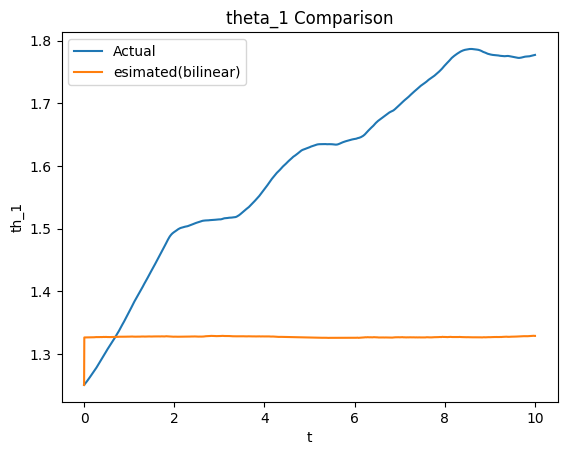

In [362]:
plt.figure()
plt.plot(T,x_val[0,:],label ='Actual')
plt.plot(T,x_est_bil[0,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[0,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_1')
plt.title('theta_1 Comparison')
plt.legend()


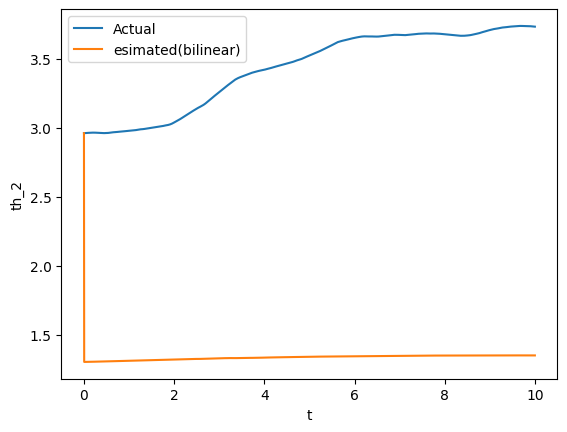

In [363]:
plt.figure()
plt.plot(T,x_val[1,:],label ='Actual')
plt.plot(T,x_est_bil[1,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[1,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_2')
plt.legend()


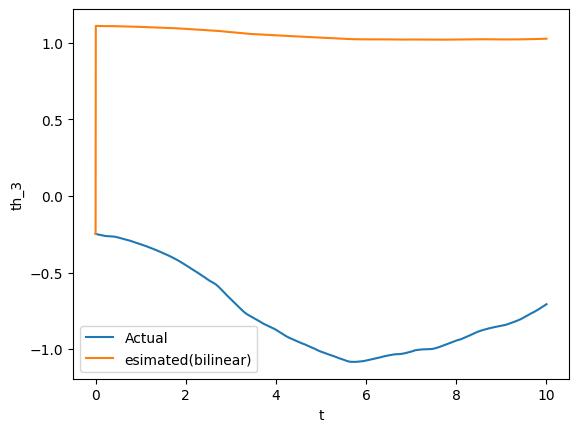

In [364]:
plt.figure()
plt.plot(T,x_val[2,:],label ='Actual')
plt.plot(T,x_est_bil[2,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[2,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_3')
plt.legend()

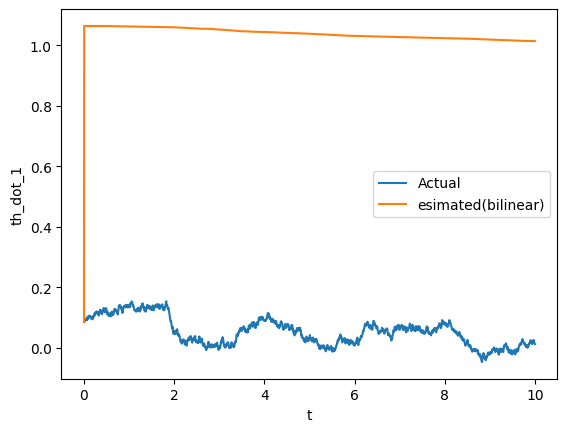

In [365]:
plt.figure()
plt.plot(T,x_val[3,:],label ='Actual')
plt.plot(T,x_est_bil[3,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[3,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_dot_1')
plt.legend()

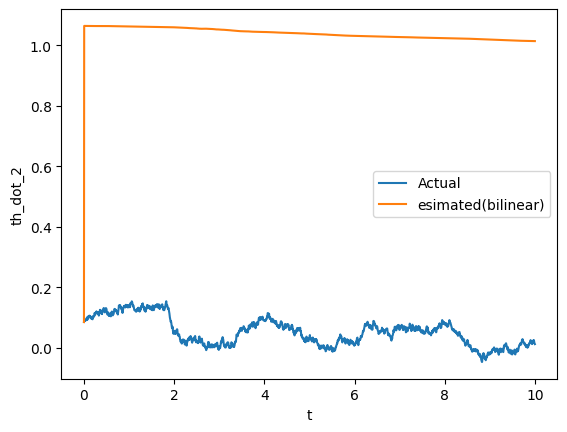

In [366]:
plt.figure()
plt.plot(T,x_val[3,:],label ='Actual')
plt.plot(T,x_est_bil[3,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[3,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_dot_2')
plt.legend()

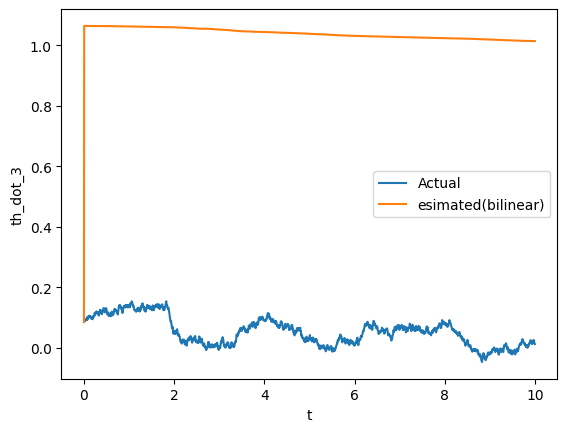

In [367]:
plt.figure()
plt.plot(T,x_val[3,:],label ='Actual')
plt.plot(T,x_est_bil[3,:],label = 'esimated(bilinear)')
# plt.plot(T,x_est_lin[3,:],label = 'esimated(linear)')
plt.xlabel('t')
plt.ylabel('th_dot_3')
plt.legend()

In [368]:
error_mse_bil = np.sqrt(np.square(x_est_bil[0:2,:]-x_val[0:2,:]).mean(axis=0))
error_mse_lin = np.sqrt(np.square(x_est_lin[0:2,:]-x_val[0:2,:]).mean(axis=0))

Text(0.5, 1.0, 'error evolution')

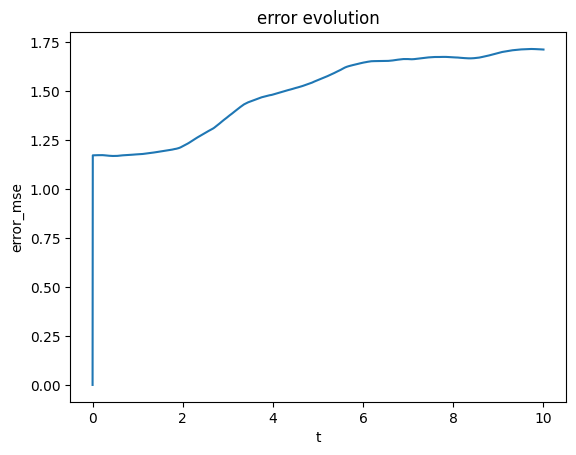

In [369]:
plt.figure()
plt.plot(T,error_mse_bil)
plt.xlabel('t')
plt.ylabel('error_mse')
plt.title('error evolution')

In [370]:
np.mean(error_mse_bil)


1.4920982186704934

Text(0.5, 1.0, 'error evolution')

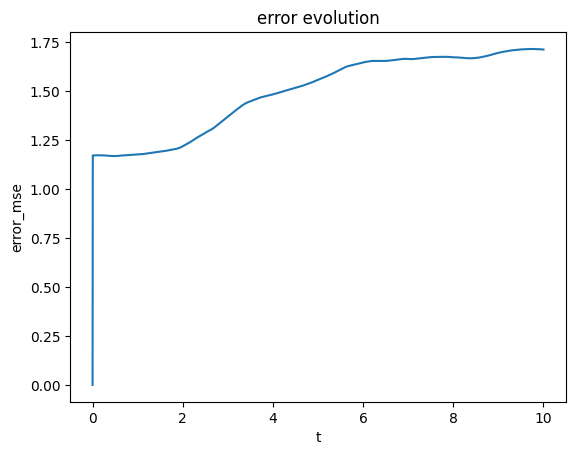

In [371]:
plt.figure()
plt.plot(T,error_mse_lin)
plt.xlabel('t')
plt.ylabel('error_mse')
plt.title('error evolution')

In [372]:
np.mean(error_mse_lin)

1.4931852202247418